In [1]:
pip install -U Classiq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.1/77.1 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.6/151.6 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 387.9/387.9 kB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 46.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 34.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 50.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.7/10.7 MB 46.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.4/6.4 MB 56.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 3

In [2]:
import classiq
classiq.authenticate()

Your user code: GRHR-SRVS
If a browser doesn't automatically open, please visit this URL from any trusted device: https://auth.classiq.io/activate?user_code=GRHR-SRVS


In [3]:
from classiq import *

size = 4
nodes = 2**size


@qfunc
def prepare_minus(x: QBit):
  X(x)
  H(x)


@qfunc
def diffuzer_oracle(aux: Output[QNum],x:QNum):
  aux^=(x!=0)


@qfunc
def zero_diffuzer(x: QNum):
  aux = QNum('aux')
  allocate(1,aux)
  within_apply(compute=lambda: prepare_minus(aux),
              action=lambda: diffuzer_oracle)


def W_iteration(i:int, vertices: QNum, adjacent_vertices:QNum):
    prob = [0] * nodes
    if (i !=nodes - 1 ) and (i != 0):
      prob[(i+1)%nodes]= 0.5
      prob[(i-1)%nodes]= 0.5
    elif (i ==nodes - 1) :
      prob[(i-1)%nodes]= 1
    else:
      prob[(i+1)%nodes]= 1
    print(f'State={i}, prob vec ={prob}')

    control(ctrl=vertices==i,
            operand=lambda: within_apply(
              compute= lambda: inplace_prepare_state(probabilities=prob, bound=0.01, target=adjacent_vertices),
              action= lambda: zero_diffuzer(adjacent_vertices)))


@qfunc
def W_operator(vertices:QNum, adjacent_vertices: QNum):
    for i in range(2**size):
      W_iteration(i, vertices, adjacent_vertices)


@qfunc
def edge_oracle(res:Output[QBit], vertices: QNum, adjacent_vertices: QNum):
  res |= (((vertices - adjacent_vertices) == 1) | ((vertices - adjacent_vertices) == -1))


@qfunc
def bitwise_swap(x: QArray[QBit], y:QArray[QBit]):
  repeat(count= x.len,
    iteration= lambda i: SWAP(x[i],y[i]))


@qfunc
def S_operator(vertices:QNum, adjacent_vertices: QNum):
    res = QNum('res')
    edge_oracle(res,vertices,adjacent_vertices)
    control(ctrl= res==1,
        operand= lambda: bitwise_swap(vertices,adjacent_vertices))

@qfunc
def main(vertices:Output[QNum], adjacent_vertices:Output[QNum]):

  allocate(size,vertices)
  hadamard_transform(vertices)
  allocate(size,adjacent_vertices)

  W_operator(vertices,adjacent_vertices)
  S_operator(vertices,adjacent_vertices)

qmod = create_model(main)
qprog = synthesize(qmod)
show(qprog)

State=0, prob vec =[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=1, prob vec =[0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=2, prob vec =[0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=3, prob vec =[0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=4, prob vec =[0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=5, prob vec =[0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=6, prob vec =[0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0]
State=7, prob vec =[0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0]
State=8, prob vec =[0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0]
State=9, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0]
State=10, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0]
State=11, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0]
State=12, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0]
State=13, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 

## Quantum Walk Algorithm Operator  - 16 Nodes : Explanation

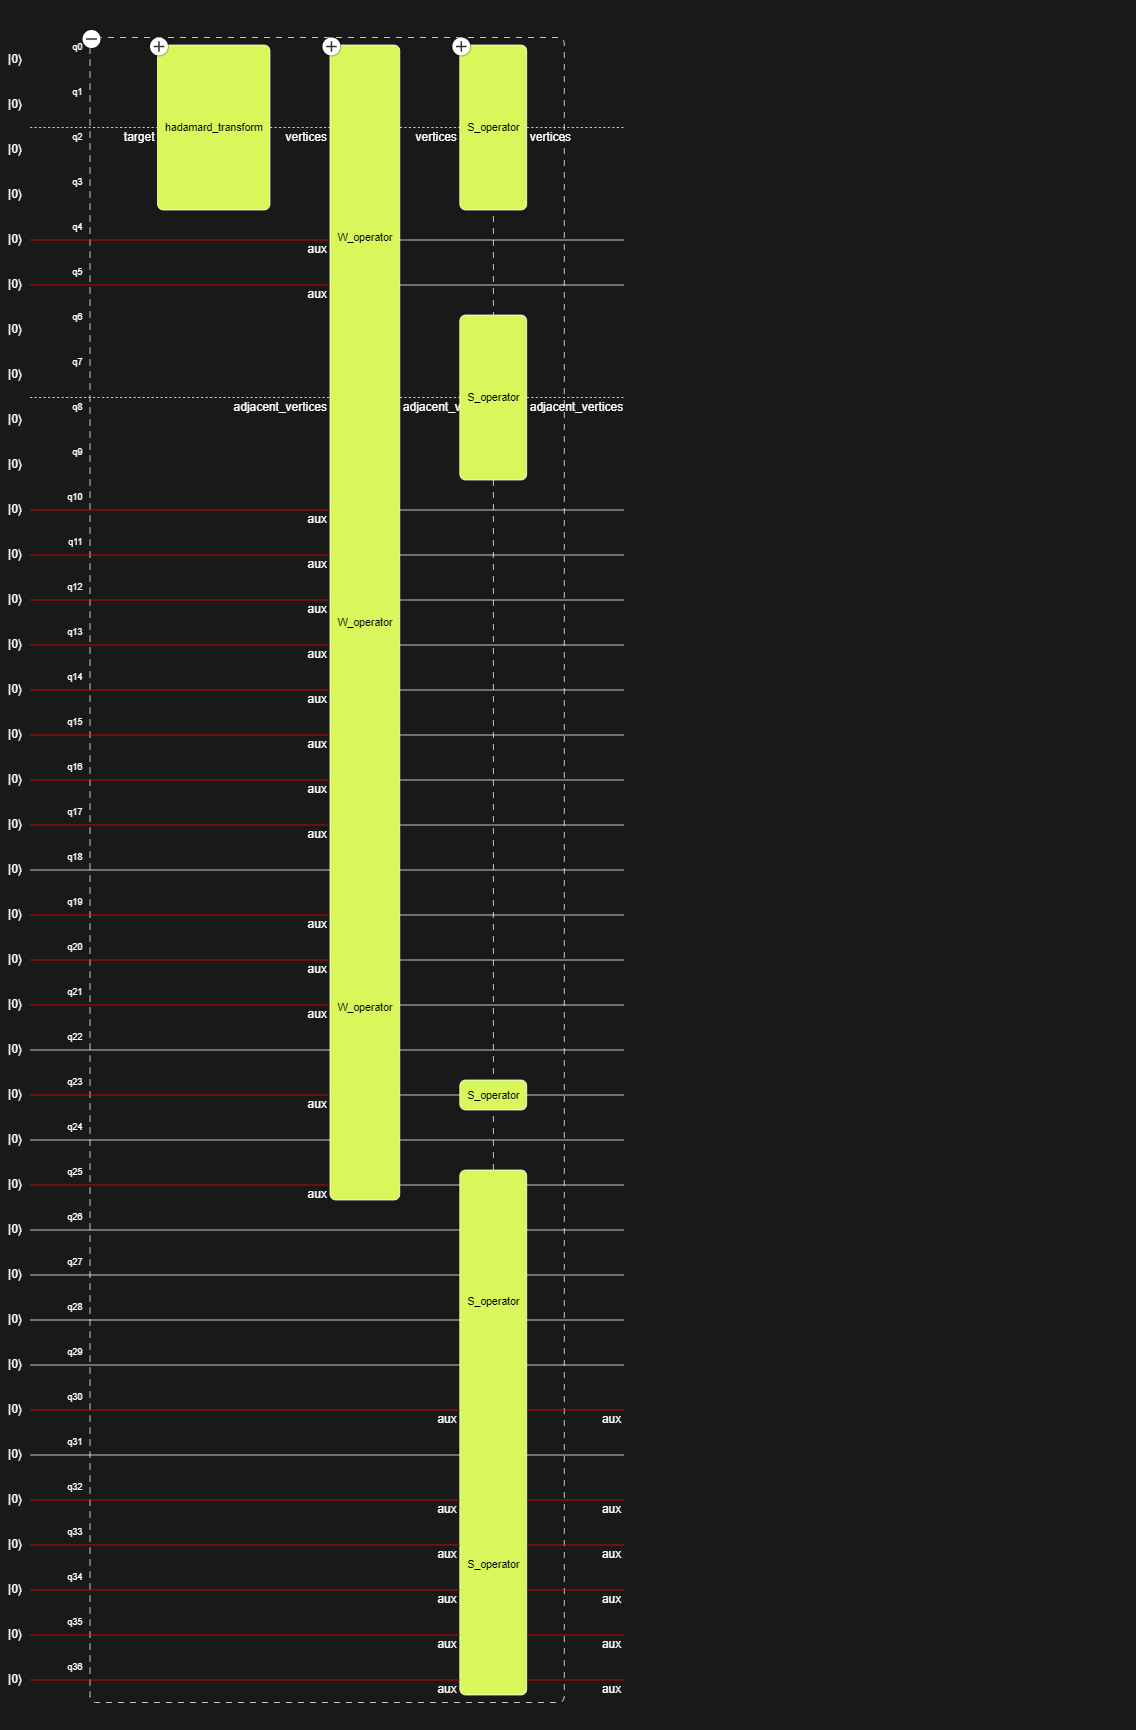

This Code is implements the Quantum Walk Algorithm with 16 nodes that is 16 dots on a line, this complete program is executed in the main function using the defined the functions.

We are using the classiq library to implement this algorithmic functionality using 4 qubit system in which size is declared as 4, such that it provides the 16 states which each node is represented using a one of the 16 states.

Quantum Functions:

1. Preparation of |-⟩ : Applies a Hadamard gate (H) followed by a Pauli-X gate (X) to qubit x. This prepares the qubit in a superposition state with a minus sign.

2. Diffuser Oracle: Oracle takes two qubits, aux and x. It performs a bitwise XOR operation between the aux qubit and a value of 1 if x is not equal to zero. Essentially, it flags the aux qubit if x is non-zero.

3. Zero Diffuser: This function allocates one additional qubit aux and then applies the diffuser_oracle function with x and the newly allocated aux qubit. It uses within_apply which ensures the oracle function is called only within a control block.

4. Edge Oracle: This function takes an output qubit res and two registers vertices and adjacent_vertices.It uses a bitwise XOR operation between the sum of vertices and adjacent_vertices modulo 2. It sets the res qubit to 1 if the result is odd, essentially checking if there's an edge between the represented vertices.

5. Bitwise Swap: This function takes two arrays of qubits (x and y) and performs a SWAP operation on each corresponding qubit within the arrays.

6. S-Operator: This function defines an output qubit res. It calls the edge_oracle with vertices, adjacent_vertices, and res. It applies a control operation. If the value of res is 1 (meaning there's an edge), it applies a bitwise_swap function on vertices and adjacent_vertices. This effectively swaps the states of connected vertices.

W-iteration and W-Operator:

1. W-iteration defines a probability vector prob with equal probability for states i+1 and i-1 on the vertices register (representing a walk on the graph) and zero probability for other states.

2. It then applies a control operation. If the state in the vertices register matches the index i, it performs a within_apply block.

3. Inside the block, it applies the inplace_prepare_state function (not shown in the code) to set the state of adjacent_vertices according to the probability vector.

4. It also calls the zero_diffuser function on adjacent_vertices.

5. W-Operator iterates through all possible states (2^size) and calls the W_iteration function for each state with the provided vertices and adjacent_vertices registers.


To establish an equal superposition of all potential states (positions), Hadamard gates are applied at the beginning of the circuit. This gives the walker a non-zero probability of being at any one of the 16 nodes. The probability for shifting to neighboring vertices are prepared by the state preparation block. This function determines the probability amplitudes for the walker to travel to each node's nearby nodes. To make sure the probabilities are dispersed correctly, the diffusion operator is applied by the zero diffuser block. This operation is made easier by the auxiliary qubit (aux). Every node receives the operations one after the other.

The edge oracle block determines whether an edge connects the current vertex to a neighboring vertex. It sets a flag qubit to indicate whether the vertices are close to one another. The bitwise swap operation switches the states of the vertices and adjacent_vertices qubits if the edge oracle shows adjacency. With this swap, the walker's movement to the nearby vertex is simulated. The bitwise swap operation is conditional on the adjacency check performed by the edge_oracle, as indicated by the dashed control lines. As a result, the swap will only take place if the vertices are in fact adjacent.